In [2]:
import os
import sys
from dotenv import load_dotenv
import yaml

load_dotenv()
DVUTILS_LOCAL_CLONE_PATH = os.environ.get("DVUTILS_LOCAL_CLONE_PATH")
sys.path.insert(0, DVUTILS_LOCAL_CLONE_PATH)

from utils_io import *

## Define Parameters

In [3]:
## Set the PCA Layers configuration file: PCA Geographies and PCA Types
yaml_file = 'pca-layers.yml'

## Create ArcGIS Client
client = create_arcgis_client()

Admin ArcGIS client created


## Create Functions

In [4]:
def simplify_geoms(gdf):
    """Simplify and clean Geometries by applying dissolve, explode,
    simplify and repair_geometry functions
    """
    print(f"GDF Geometry Types: {gdf.geom_type.unique()}")
    ## Convert Multipart features to Single part
    gdf = gdf.dissolve(by=None).reset_index(drop=True)
    gdf = gdf.explode(index_parts=False).reset_index(drop=True)
    ## Repair Geometries
    gdf = repair_geometry(gdf.query("geometry.notnull()"))
    print(f"GDF Geometry Types: {gdf.geom_type.unique()}")

    return gdf


def create_footprint(gdf, flag_name, dist=False):
    """Create Area Footprint from GeoDataframe and assign Flag Name
    to Column
    """
    ## Simplify Dataset
    gdf = gdf[["geometry"]].copy()
    gdf = simplify_geoms(gdf)
    ## Set Area Name
    gdf[flag_name] = 1

    return gdf


def create_footprints_for_dict(input_dict, flag_name):
    """Iterate through Dictionary object and create area footprints
    by applying the create_footprint function
    """
    for k, v in input_dict.items():
        print(f"Creating Footprint for dataset: {k}")
        try:
            data_key = "data" if "data" in v else "data_load"
            print(f"Using: {data_key}")
            v["footprint"] = create_footprint(v[data_key], v[flag_name])
            v["footprint"].plot()
            print("Creation of Footprint completed\n")
        except:
            print("Creation of Footprint failed!\n")

In [5]:
def assign_footprint(
                gdf_base,
                gdf_over,
                flag_name,
                gdf_base_id="gdf_id",
                return_share=True
                ):
    """Given an Input Geodataframe, runs Spatial Overlay
    to p10 Parcels and returns Parcel Assignment crosswalk
    """
    ## Check for gdf_id or create
    if (gdf_base_id == 'gdf_id') and (not gdf_base_id in gdf_base.columns):
        print('Creating gdf_id')
        gdf_base.reset_index(drop=True, inplace=True)
        gdf_base['gdf_id'] = gdf_base.index
    ## Create Base GeoDataframe to Input GeoDataframe correspondence
    print('Creating Base GeoDataframe to Input GeoDataframe correspondence')
    gdf_over_corresp = geo_assign_fields(
        id_df=gdf_base[[gdf_base_id, 'geometry']],
        id_field=gdf_base_id,
        overlay_df=gdf_over,
        overlay_fields=[flag_name],
        return_intersection_area=return_share,
    )
    ## Merge p10 Parcels GeoDataframe to Input GeoDataframe using correspondence,
    ## return Dataframe
    gdf_base_fields = [i for i in gdf_base.columns if i != "geometry"]
    if return_share:
        if (not 'area_sq_m' in gdf_base.columns):
            print('Creating area_sq_m')
            gdf_base['area_sq_m'] = gdf_base.geometry.area
            gdf_base_fields.append("area_sq_m")
    base_over = pd.merge(gdf_base[gdf_base_fields], gdf_over_corresp, on=gdf_base_id, how="left")
    if return_share:
        intersect_area_col = f"{flag_name}_intersect_sq_m"
        share_pct_col = f"{flag_name}_share_pct"
        base_over.rename(columns={"intersection_sq_m": intersect_area_col}, inplace=True)
        base_over[share_pct_col] = base_over[intersect_area_col] / base_over["area_sq_m"]

    return base_over


def assign_footprints_from_dictionary(base_dict, overlay_dict, flag_col):
    """
    Assigns a footprint flag to base_dict for each item in the overlay_dict, based on flag_name.
    """
    for pca_type, type_att in overlay_dict.items():
        try:
            print(f'Dataset {pca_type}: Starting Assignment of Footprint')
            flag_name = type_att[flag_col]
            type_att['assignment'] = assign_footprint(
                gdf_base=base_dict['data_load'],
                gdf_over=type_att['footprint'],
                flag_name = flag_name
                )
            print(f'Dataset {pca_type}: Assignment of Footprint complete\n')
        except:
            print(f'Dataset {pca_type}: Assignment of Footprint failed!\n')
            pass

## Load PCA Layers definitions from YAML

In [6]:
## Load PCA Geographies from YAML
with open(yaml_file, 'r') as file:
    pca_geo = yaml.safe_load(file)['pca_geo']
print(pca_geo)

## Load PCA Types from YAML
with open(yaml_file, 'r') as file:
    pca_types = yaml.safe_load(file)['pca_types']
print([i for i in pca_types.keys()])

## Load UGB from YAML
with open(yaml_file, 'r') as file:
    ugb = yaml.safe_load(file)['ugb']
print(ugb)

{'name': 'PCA Geographies', 'agol': 'https://www.arcgis.com/home/item.html?id=8f4a98b1bb32402db22ba7379ea062a9', 'url': 'https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/PBA50_PCA_Polygons/FeatureServer/2'}
['natural_land', 'working_land', 'urban_greening', 'recreation', 'climate_adaptation']
{'flag': 'ugb', 'name': 'EN4_Urban_Growth_Boundary', 'agol': 'https://mtc.maps.arcgis.com/home/item.html?id=9e16c1e49bcf40f5817d26a7684e1ad4', 'url': 'https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/EN4_Urban_Growth_Boundary/FeatureServer/0'}


## Load PCA Layers from AGOL Datasets

Breaking feature service layer IDs into 1 chunks


<Axes: >

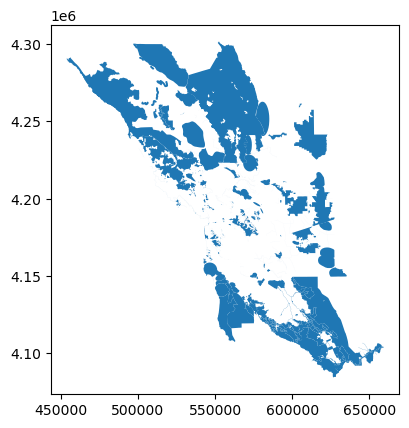

In [7]:
## Load PCA Geographies
## Pull GeoTable from AGOL as GeoDataframe
pca_geo['data_load'] = pull_geotable_agol(pca_geo['url'], client=client)

pca_geo['data'] = pca_geo['data_load'].copy()
pca_geo['data'].reset_index(drop=True, inplace=True)
pca_geo['data']['gdf_id'] = 1 + pca_geo['data'].index

pca_geo['data'].plot()

natural_land
https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/Natural_Land_PCA_Eligibility_v0a/FeatureServer/0
Loading data for natural_land
Breaking feature service layer IDs into 3 chunks
Data loaded successfully

working_land
https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/Working_Land_PCA_Eligibility/FeatureServer/225
Loading data for working_land
Breaking feature service layer IDs into 1 chunks
Data loaded successfully

urban_greening
https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/Urban_Greening_PCA_Eligibility/FeatureServer/226
Loading data for urban_greening
Breaking feature service layer IDs into 1 chunks
Data loaded successfully

recreation
https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/Regional_Recreation_PCA_Eligibility/FeatureServer/227
Loading data for recreation
Breaking feature service layer IDs into 1 chunks
Data loaded successfully

climate_adaptation
https://services3.arcgis.com/i2dkYWmb4wHvY

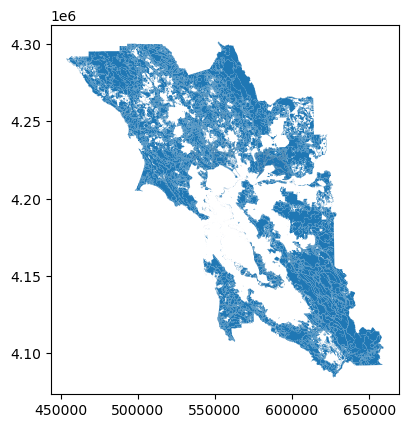

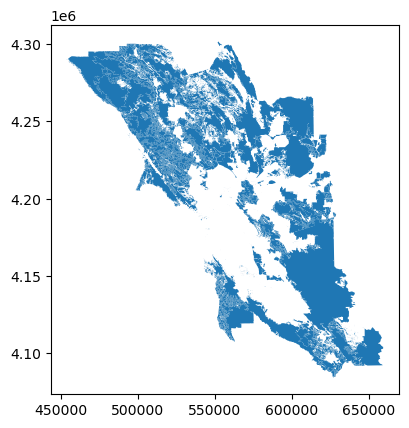

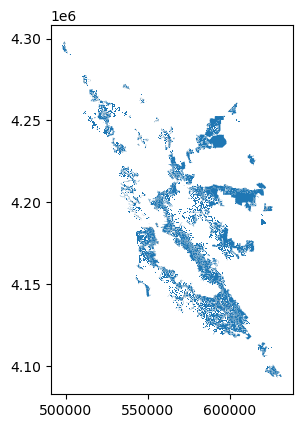

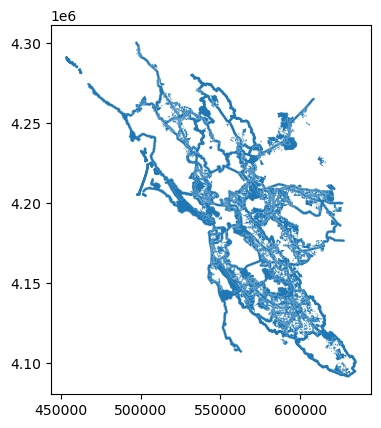

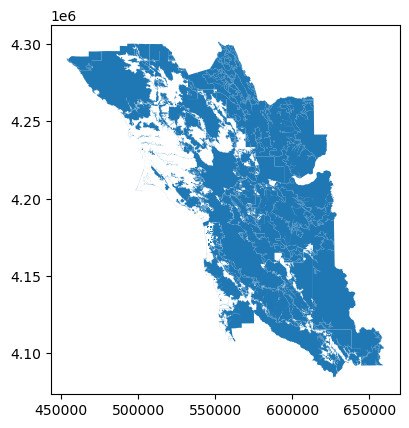

In [8]:
## Load PCA types
for i in pca_types.keys():
    print(i)
    print(pca_types[i]['url'])
    try:
        print(f"Loading data for {i}")
        ## Pull GeoTable from AGOL as GeoDataframe
        pca_types[i]['data_load'] = pull_geotable_agol(pca_types[i]['url'], client=client)
        pca_types[i]['data_load'].plot()
        print("Data loaded successfully\n")
    except:
        print(f"Failed to load data for {i}!\n")


Breaking feature service layer IDs into 6 chunks


<Axes: >

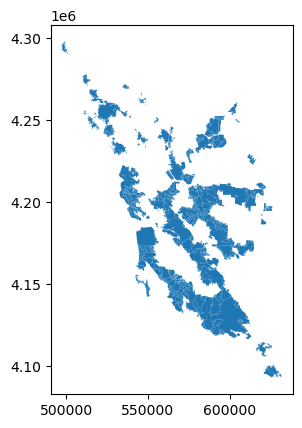

In [9]:
## Load UGB
## Pull GeoTable from AGOL as GeoDataframe
ugb['data_load'] = pull_geotable_agol(ugb['url'], client=client)

ugb['data'] = ugb['data_load'].copy()
ugb['data'].reset_index(drop=True, inplace=True)
ugb['data']['ugb_geo_id'] = 1 + ugb['data'].index

ugb['data'].plot()

## Flag #1 PCA Geographies to PCA Types

### Create Footprints for PCA Types

Creating Footprint for dataset: natural_land
Using: data_load
GDF Geometry Types: ['Polygon' 'MultiPolygon']
Geodataframe contains valid geometry. No repair necessary.
GDF Geometry Types: ['Polygon']
Creation of Footprint completed

Creating Footprint for dataset: working_land
Using: data_load
GDF Geometry Types: ['MultiPolygon']
Geodataframe contains valid geometry. No repair necessary.
GDF Geometry Types: ['Polygon']
Creation of Footprint completed

Creating Footprint for dataset: urban_greening
Using: data_load
GDF Geometry Types: ['MultiPolygon']
Geodataframe contains valid geometry. No repair necessary.
GDF Geometry Types: ['Polygon']
Creation of Footprint completed

Creating Footprint for dataset: recreation
Using: data_load
GDF Geometry Types: ['MultiPolygon' None]
Geodataframe contains valid geometry. No repair necessary.
GDF Geometry Types: ['Polygon']
Creation of Footprint completed

Creating Footprint for dataset: climate_adaptation
Using: data_load
GDF Geometry Types: ['Mul

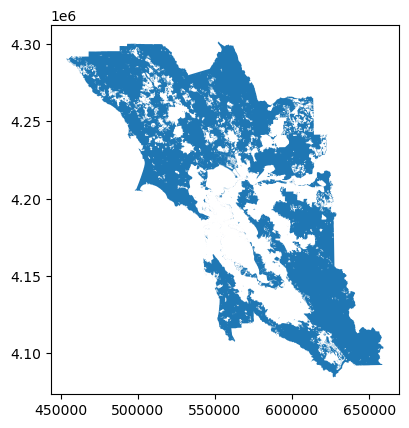

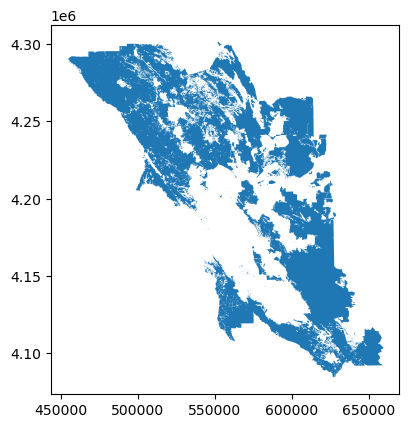

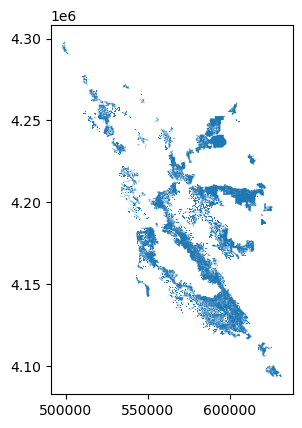

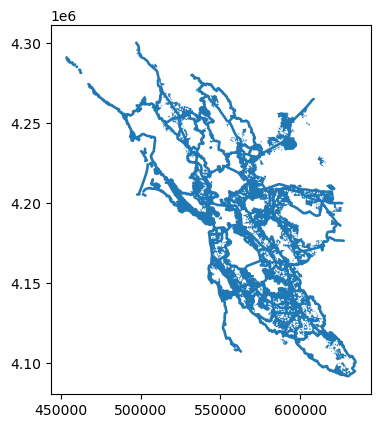

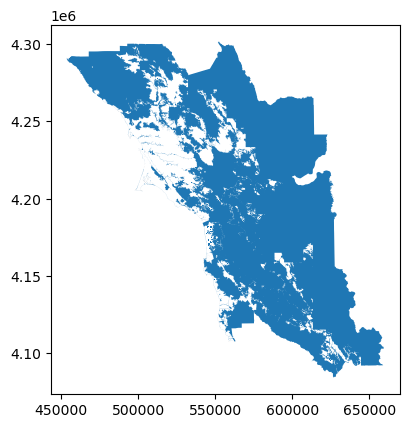

In [10]:
create_footprints_for_dict(pca_types, 'flag')

### Assign PCA Type Footprints to PCA Geographies

In [11]:
assign_footprints_from_dictionary(pca_geo, pca_types, 'flag')

Dataset natural_land: Starting Assignment of Footprint
Creating gdf_id
Creating Base GeoDataframe to Input GeoDataframe correspondence


/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


took 6.5978 seconds
Creating area_sq_m
Dataset natural_land: Assignment of Footprint complete

Dataset working_land: Starting Assignment of Footprint
Creating Base GeoDataframe to Input GeoDataframe correspondence


/Users/jcroff/Documents/GitHub/dvutils/utils_analytics.py:2569: UserWarning: `keep_geom_type=True` in overlay resulted in 125 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  join_df = gpd.overlay(id_df, overlay_df, how="intersection")
/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


took 6.8558 seconds
Dataset working_land: Assignment of Footprint complete

Dataset urban_greening: Starting Assignment of Footprint
Creating Base GeoDataframe to Input GeoDataframe correspondence


/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


took 19.5666 seconds
Dataset urban_greening: Assignment of Footprint complete

Dataset recreation: Starting Assignment of Footprint
Creating Base GeoDataframe to Input GeoDataframe correspondence


/Users/jcroff/Documents/GitHub/dvutils/utils_analytics.py:2569: UserWarning: `keep_geom_type=True` in overlay resulted in 156 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  join_df = gpd.overlay(id_df, overlay_df, how="intersection")
/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


took 5.3653 seconds
Dataset recreation: Assignment of Footprint complete

Dataset climate_adaptation: Starting Assignment of Footprint
Creating Base GeoDataframe to Input GeoDataframe correspondence
took 27.6272 seconds
Dataset climate_adaptation: Assignment of Footprint complete



/Users/jcroff/Documents/GitHub/dvutils/utils_analytics.py:2569: UserWarning: `keep_geom_type=True` in overlay resulted in 133 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  join_df = gpd.overlay(id_df, overlay_df, how="intersection")
/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [12]:
for pca_type, type_att in pca_types.items():
    try:
        print('Displaying Assignment of Footprint for PCA Type:', pca_type)
        display(type_att['assignment'].sample(3))
    except:
        print(f'Display of Assignment of Footprint for PCA Type {pca_type} failed!')

Displaying Assignment of Footprint for PCA Type: natural_land


,OBJECTID,fipco,joinkey,lead,name,acres,typenl,typeal,typeug,typerr,...,Acreage,Shape__Area,Shape__Length,gdf_id,area_sq_m,1nl,base_sq_m,1nl_intersect_sq_m,area_share,1nl_share_pct
87,88,6075,MULTI1,San Francisco Bay Trail Project,San Francisco Bay Trail - Bay Area Ridge Trail,49.508449,1,0,0,0,...,49.508449,2.003536e+05,43997.786955,87,3.028945e+05,1.0,3.028945e+05,5.200161e+02,0.001717,0.001717
49,50,6013,CC20,East Bay Regional Park District (EBRPD),Potential Pinole Watershed Area,2904.420761,1,0,0,1,...,2904.420761,1.175377e+07,12408.010168,49,1.175379e+07,1.0,1.175379e+07,9.664819e+06,0.822273,0.822273
156,157,6075,SF9,City and County of San Francisco,Bayview Hill Natural Area,46.613414,1,0,0,1,...,46.613414,1.886378e+05,3181.901131,156,1.886379e+05,NaN,1.886379e+05,NaN,NaN,NaN


Displaying Assignment of Footprint for PCA Type: working_land


,OBJECTID,fipco,joinkey,lead,name,acres,typenl,typeal,typeug,typerr,...,Acreage,Shape__Area,Shape__Length,gdf_id,area_sq_m,1wl,base_sq_m,1wl_intersect_sq_m,area_share,1wl_share_pct
149,150,6001,AL32,City of Oakland,Oakland Priority Creeks,666.960610,1,0,1,0,...,666.960610,2.699094e+06,402295.463426,149,2.812459e+06,1.0,2.812459e+06,1.025681e+04,0.003647,0.003647
47,48,6013,CC12,"Contra Costa County, Community Development Dep...",Contra Costa County Agricultural Core,11200.899210,0,1,0,0,...,11200.899210,4.532843e+07,37043.674475,47,4.532830e+07,1.0,4.532830e+07,4.360033e+07,0.961879,0.961879
155,156,6041,MR21,Town of Fairfax,Fairfax Zone 3 - Northern Fairfax/Sleepy Hollo...,467.662006,1,0,1,1,...,467.662006,1.892561e+06,17513.089066,155,1.892550e+06,NaN,1.892550e+06,NaN,NaN,NaN


Displaying Assignment of Footprint for PCA Type: urban_greening


,OBJECTID,fipco,joinkey,lead,name,acres,typenl,typeal,typeug,typerr,...,Acreage,Shape__Area,Shape__Length,gdf_id,area_sq_m,1ug,base_sq_m,1ug_intersect_sq_m,area_share,1ug_share_pct
23,24,6001,AL22,East Bay Regional Park District (EBRPD),Chain of Lakes Area,1967.612879,1,0,0,1,...,1967.612879,7.962647e+06,11671.430596,23,7.962623e+06,1.0,7.962623e+06,2.621997e+06,0.329288,0.329288
191,192,6075,SF109,City and County of San Francisco,Northern Waterfront,129.023227,0,0,0,1,...,129.023227,5.221385e+05,25950.464222,191,5.221356e+05,1.0,5.221356e+05,3.316647e+05,0.635208,0.635208
14,15,6041,MR14,Marin Audubon Society/Marin Baylands Advocates,St. Vincent's and Silveira Properties,1690.417264,1,0,0,0,...,1690.417264,6.840876e+06,12949.620157,14,6.840849e+06,1.0,6.840849e+06,9.598659e+05,0.140314,0.140314


Displaying Assignment of Footprint for PCA Type: recreation


,OBJECTID,fipco,joinkey,lead,name,acres,typenl,typeal,typeug,typerr,...,Acreage,Shape__Area,Shape__Length,gdf_id,area_sq_m,1r,base_sq_m,1r_intersect_sq_m,area_share,1r_share_pct
16,17,6001,AL5,City of Oakland,East Bay Greenway,453.695561,1,0,0,0,...,453.695561,1.836041e+06,12322.161289,16,1.836041e+06,1.0,1.836041e+06,1.836041e+06,1.000000,1.000000
81,82,6097,SN1,Sotoyome Resource Conservation District,Upper Mark West Watershed,19576.573340,1,0,0,0,...,19576.573340,7.922358e+07,47438.745752,81,7.922355e+07,1.0,7.922355e+07,2.609638e+06,0.032940,0.032940
125,126,6085,SC51,Santa Clara Valley Open Space Authority,Coyote Valley - Mid,1448.455002,1,1,1,0,...,1448.455002,5.861689e+06,10463.958113,125,5.861694e+06,1.0,5.861694e+06,1.067552e+06,0.182123,0.182123


Displaying Assignment of Footprint for PCA Type: climate_adaptation


,OBJECTID,fipco,joinkey,lead,name,acres,typenl,typeal,typeug,typerr,...,Acreage,Shape__Area,Shape__Length,gdf_id,area_sq_m,1ca,base_sq_m,1ca_intersect_sq_m,area_share,1ca_share_pct
188,189,6075,SF106,City and County of San Francisco,Lake Merced/Ocean Beach,1215.567803,1,0,1,1,...,1215.567803,4.919228e+06,21546.684740,188,4.919257e+06,1,4.919257e+06,5.355107e+05,0.108860,0.108860
118,119,6041,MR24,City of Novato,Hill Recreation and Arroyo Avichi Creek Area,23.134975,1,1,1,1,...,23.134975,9.362392e+04,2245.541517,118,9.362358e+04,1,9.362358e+04,9.194897e+04,0.982113,0.982113
78,79,6097,SN8,Sonoma Land Trust,Sonoma Baylands,31344.379008,1,0,0,0,...,31344.379008,1.268462e+08,51820.661959,78,1.268461e+08,1,1.268461e+08,8.081049e+07,0.637075,0.637075


## Integrate Assignments of PCA Types to single Assignment file

In [13]:
data_key = "data" if "data" in pca_geo.keys() else "data_load"
pca_geo['assignment'] = pca_geo[data_key].drop(columns=['geometry'])
## Merge PCA Geographies to PCA Types Assignments 
for pca_type, type_att in pca_types.items():
    try:
        flag = type_att['flag']
        cols = ['gdf_id', flag, f"{flag}_intersect_sq_m", f"{flag}_share_pct"]
        pca_geo['assignment'] = pd.merge(
            pca_geo['assignment'],
            type_att['assignment'][cols].fillna(0),
            on='gdf_id',
            how='left'
            )
        print(f'Assignment of Footprint for PCA Type {pca_type} completed\n')
    except:
        print(f'Assignment of Footprint for PCA Type {pca_type} failed!\n')

Assignment of Footprint for PCA Type natural_land completed

Assignment of Footprint for PCA Type working_land completed

Assignment of Footprint for PCA Type urban_greening completed

Assignment of Footprint for PCA Type recreation completed

Assignment of Footprint for PCA Type climate_adaptation completed



## Flag #2 PCA to UGB

### Create Footprint for UGB

Creating Footprint for dataset: EN4_Urban_Growth_Boundary
Using: data
GDF Geometry Types: ['MultiPolygon' 'Polygon' None]
Geodataframe contains valid geometry. No repair necessary.
GDF Geometry Types: ['Polygon']
Creation of Footprint completed



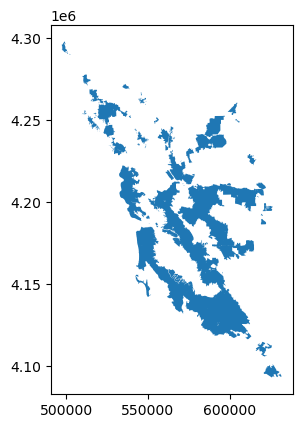

In [14]:
print(f"Creating Footprint for dataset: {ugb['name']}")
data_key = "data" if "data" in ugb.keys() else "data_load"
print(f"Using: {data_key}")
ugb["footprint"] = create_footprint(ugb[data_key], ugb['flag'])
ugb["footprint"].plot()
print("Creation of Footprint completed\n")

### Assign UGB Footprint to PCA Geographies

In [15]:
print(f"Dataset {ugb['name']}: Starting Assignment of Footprint")
data_key = "data" if "data" in pca_geo.keys() else "data_load"
print(f"Using: {data_key}")
flag_name = ugb['flag']
ugb['assignment'] = assign_footprint(
    gdf_base=pca_geo[data_key],
    gdf_over=ugb['footprint'],
    flag_name = flag_name
    )
print(f"Dataset {ugb['name']}: Assignment of Footprint complete\n")

Dataset EN4_Urban_Growth_Boundary: Starting Assignment of Footprint
Using: data
Creating Base GeoDataframe to Input GeoDataframe correspondence
took 2.0601 seconds
Creating area_sq_m
Dataset EN4_Urban_Growth_Boundary: Assignment of Footprint complete



/Users/jcroff/Documents/GitHub/dvutils/utils_analytics.py:2569: UserWarning: `keep_geom_type=True` in overlay resulted in 598 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  join_df = gpd.overlay(id_df, overlay_df, how="intersection")
/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [16]:
ugb['assignment'].sample(3).T

,136,80,27
OBJECTID,137,81,28
fipco,6075,6097,6041
joinkey,SF12,SN7,MR2
lead,City and County of San Francisco,Sonoma Land Trust,Tomales Bay Watershed Council
name,Palou Phelps Natural Area,Pitkin Marsh - Atascadero Creek Watershed,Third Valley Creek/Chicken Ranch Beach Conserv...
acres,3.085074,2341.581897,25.664563
typenl,1,1,1
typeal,0,0,0
typeug,0,0,0
typerr,1,0,0


## Integrate Assignments of UGB to single Assignment file

In [17]:
## Assign UGB Footprint to PCA Geographies
## Assignment #1 should be run first
flag = ugb['flag']
cols = ['gdf_id', flag, f"{flag}_intersect_sq_m", f"{flag}_share_pct"]
pca_geo['assignment'] = pd.merge(
            pca_geo['assignment'],
            ugb['assignment'][cols].fillna(0),
            on='gdf_id',
            how='left'
            )
print(f"Assignment of Footprint for {ugb['flag']} completed")

Assignment of Footprint for ugb completed


### Check samples from Integrated Assignments table

In [18]:
pca_geo['assignment'].sample(3).T

,142,18,128
OBJECTID,143,19,129
fipco,6085,6041,6085
joinkey,SC40,MR11,SC52
lead,Santa Clara Valley Open Space Authority,Marin County Parks and Open Space Department,Santa Clara Valley Open Space Authority
name,Sierra Vista,Tiburon Ridge Lands,Coyote Valley - South
acres,2020.904697,566.623949,1611.047401
typenl,1,1,0
typeal,1,0,1
typeug,0,0,0
typerr,1,0,1


## Export Integrated Assignments #1 and #2 as Table

In [19]:
col_order = ['gdf_id'] + [c for c in pca_geo['assignment'].columns if c != 'gdf_id']
pca_geo['assignment'][col_order].fillna(0).to_csv('pca_type_assignment.csv', index=False)

## Flag #3 PCA to PCA

In [20]:
def overlay_surface_percentage_matrix(gdf, id_column='gdf_id', how='intersection'):
    """
    Creates a matrix of overlay surface percentages for each pair of features in the GeoDataFrame.
    
    Parameters:
    gdf (GeoDataFrame): The input GeoDataFrame.
    id_column (str): The name of the column with unique numeric identifiers.
    how (str): The type of overlay operation (default is 'intersection').
    
    Returns:
    matrix (DataFrame): A DataFrame where each cell (i, j) contains the percentage of the surface area of feature i
                        that is overlapped by feature j.
    """
    if id_column not in gdf.columns:
        raise ValueError(f"GeoDataFrame must contain a column named '{id_column}'")

    ids = gdf[id_column].values
    matrix = pd.DataFrame(index=ids, columns=ids, dtype=float)
    
    for i, id_i in enumerate(ids):
        print(f"Processing feature {i + 1} of {len(ids)}")
        feature_i = gdf[gdf[id_column] == id_i]
        for j, id_j in enumerate(ids):
            if id_i == id_j:
                # The percentage of overlay with itself is 100%
                matrix.at[id_i, id_j] = 100.0
            else:
                feature_j = gdf[gdf[id_column] == id_j]
                overlay_result = gpd.overlay(feature_i, feature_j, how=how, keep_geom_type=True)
                
                if not overlay_result.empty:
                    # Calculate the percentage of the surface area of feature i that is overlapped by feature j
                    area_i = feature_i.geometry.area.values[0]
                    area_overlay = overlay_result.geometry.area.sum()
                    percentage_overlay = (area_overlay / area_i) * 100
                else:
                    percentage_overlay = 0.0
                
                matrix.at[id_i, id_j] = percentage_overlay
    
    return matrix

In [21]:
# Perform the overlay matrix operation
pca_geo['matrix'] = overlay_surface_percentage_matrix(pca_geo['data'], id_column='gdf_id', how='intersection')


Processing feature 1 of 208
Processing feature 2 of 208
Processing feature 3 of 208
Processing feature 4 of 208
Processing feature 5 of 208
Processing feature 6 of 208
Processing feature 7 of 208
Processing feature 8 of 208
Processing feature 9 of 208
Processing feature 10 of 208
Processing feature 11 of 208
Processing feature 12 of 208
Processing feature 13 of 208
Processing feature 14 of 208
Processing feature 15 of 208
Processing feature 16 of 208
Processing feature 17 of 208
Processing feature 18 of 208
Processing feature 19 of 208
Processing feature 20 of 208
Processing feature 21 of 208
Processing feature 22 of 208
Processing feature 23 of 208
Processing feature 24 of 208
Processing feature 25 of 208
Processing feature 26 of 208
Processing feature 27 of 208
Processing feature 28 of 208
Processing feature 29 of 208
Processing feature 30 of 208
Processing feature 31 of 208
Processing feature 32 of 208
Processing feature 33 of 208
Processing feature 34 of 208
Processing feature 35 o

/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


Processing feature 72 of 208
Processing feature 73 of 208
Processing feature 74 of 208
Processing feature 75 of 208
Processing feature 76 of 208
Processing feature 77 of 208
Processing feature 78 of 208
Processing feature 79 of 208
Processing feature 80 of 208
Processing feature 81 of 208
Processing feature 82 of 208
Processing feature 83 of 208
Processing feature 84 of 208
Processing feature 85 of 208
Processing feature 86 of 208
Processing feature 87 of 208
Processing feature 88 of 208
Processing feature 89 of 208
Processing feature 90 of 208
Processing feature 91 of 208
Processing feature 92 of 208
Processing feature 93 of 208
Processing feature 94 of 208
Processing feature 95 of 208
Processing feature 96 of 208
Processing feature 97 of 208
Processing feature 98 of 208
Processing feature 99 of 208
Processing feature 100 of 208
Processing feature 101 of 208
Processing feature 102 of 208
Processing feature 103 of 208
Processing feature 104 of 208
Processing feature 105 of 208
Processi

/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


Processing feature 170 of 208
Processing feature 171 of 208


/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


Processing feature 172 of 208
Processing feature 173 of 208


/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


Processing feature 174 of 208
Processing feature 175 of 208
Processing feature 176 of 208
Processing feature 177 of 208
Processing feature 178 of 208
Processing feature 179 of 208
Processing feature 180 of 208
Processing feature 181 of 208
Processing feature 182 of 208
Processing feature 183 of 208
Processing feature 184 of 208
Processing feature 185 of 208
Processing feature 186 of 208
Processing feature 187 of 208
Processing feature 188 of 208
Processing feature 189 of 208
Processing feature 190 of 208
Processing feature 191 of 208
Processing feature 192 of 208
Processing feature 193 of 208
Processing feature 194 of 208
Processing feature 195 of 208
Processing feature 196 of 208
Processing feature 197 of 208
Processing feature 198 of 208
Processing feature 199 of 208
Processing feature 200 of 208
Processing feature 201 of 208
Processing feature 202 of 208
Processing feature 203 of 208
Processing feature 204 of 208
Processing feature 205 of 208
Processing feature 206 of 208
Processing

### Export PCA to PCA Overlay Matrix

In [22]:
pca_geo['matrix'].fillna(0).to_csv('pca_matrix.csv', index=True)